In [ ]:
import cv2 as cv
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt

original = cv.imread("ex.jpeg") #이미지파일을 BGR로 읽어서 original에 저장
original=cv.cvtColor(original,cv.COLOR_BGR2RGB) #BGR이던 original을 RGB로 변경

img_gray = cv.cvtColor(original,cv.COLOR_RGB2GRAY) #GRAYSCALE로 변경후 img_gray에 저장

kernel = np.array(np.multiply(np.mat('2,4,5,4,2;4,9,12,9,4;5,12,15,12,5;4,9,12,9,4;2,4,5,4,2'),1/159))
stage1 = cv.filter2D(img_gray, -1, kernel)
y,x=img_gray.shape
low_th=20
high_th=100

In [ ]:
#stage2
Gx_kernel = np.array(np.mat('-1,0,1;-2,0,2;-1,0,1'))
Gx = cv.filter2D(stage1,cv.CV_32F,Gx_kernel)  

Gy_kernel = np.array(np.mat('-1,-2,-1;0,0,0;1,2,1'))
Gy = cv.filter2D(stage1,cv.CV_32F,Gy_kernel) 

GI=np.sqrt(Gx**2.0+Gy**2.0)
GI=np.array(GI,dtype=np.uint8)

angle= np.arctan2(Gy,Gx)*(180/np.pi) # angle계산

#angle값 4개방향으로 변경
angle[np.logical_or(np.logical_and(angle<22.5,angle>-22.5),angle>157.5,angle<-157.5)]=0
angle[np.logical_or(np.logical_and(angle<67.5,angle>22.5),np.logical_and(angle<-112.5,angle>-157.5))]=45
angle[np.logical_or(np.logical_and(angle<112.5,angle>67.5),np.logical_and(angle<-67.5,angle>-112.5))]=90
angle[np.logical_or(np.logical_and(angle<157.5,angle>112.5),np.logical_and(angle<-22.5,angle>-67.5))]=135

ret,stage2 = cv.threshold(GI,low_th,255,cv.THRESH_TOZERO) #candidate edge pixels 만 남기기 위해 low threshold사용

In [ ]:
#Stage3
stage3=np.zeros((y,x),dtype=np.uint8)

#Non-maximum suppression
for i in range(y):
    for j in range(x):
        a=[]
        b=[]
        k=0
        l=0
        if(stage2[i][j]!=0):
            if angle[i,j]==0:
                    while((j+k)!=x and stage2[i][j+k]!=0):
                        a.insert(k,stage2[i][j+k])
                        k+=1
                    while((j-l)!=0 and stage2[i][j-l]!=0):
                        b.insert(l,stage2[i][j-l])
                        l+=1
                    if(stage2[i][j]>=max(a) and stage2[i][j]>=max(b)):
                        stage3[i][j]=stage2[i][j]

            elif angle[i,j]==45:
                    while((j+k)!=x and (i+k)!=y and stage2[i+k][j+k]!=0):
                        a.insert(k,stage2[i+k][j+k])
                        k+=1 
                    while((j-l)!=0 and (i-l)!=0 and stage2[i-l][j-l]!=0):
                        b.insert(l,stage2[i-l][j-l])
                        l+=1
                    if(stage2[i][j]>=max(a) and stage2[i][j]>=max(b)):
                        stage3[i][j]=stage2[i][j]

            elif angle[i,j]==90:
                    while((i+k)!=y and stage2[i+k][j]!=0):
                        a.insert(k,stage2[i+k][j])
                        k+=1
                    while((i-l)!=0 and stage2[i-l][j]!=0):
                        b.insert(l,stage2[i-l][j])
                        l+=1
                    if(stage2[i][j]>=max(a) and stage2[i][j]>=max(b)):
                        stage3[i][j]=stage2[i][j]

            elif angle[i,j]==135:
                    while((j+k)!=x and (i-k)!=0 and stage2[i-k][j+k]!=0):
                        a.insert(k,stage2[i-k][j+k])
                        k+=1
                    while((j-l)!=0 and (i+l)!=y and stage2[i+l][j-l]!=0):
                        b.insert(l,stage2[i+l][j-l])
                        l+=1
                    if(stage2[i][j]>=max(a) and stage2[i][j]>=max(b)):
                        stage3[i][j]=stage2[i][j


In [ ]:
# Stage 4
strong=np.zeros((y,x),dtype=np.uint8)
weak=np.zeros((y,x),dtype=np.uint8)
tracking=np.zeros((y,x),dtype=np.uint8)

for i in range(y):
    for j in range(x):
        if stage3[i][j]>high_th: #high threshold보다 크면 strong edge
            strong[i][j]=stage3[i][j]
        elif stage3[i][j]>low_th: #high threshold와 low threshold사이면 weak edge
            weak[i][j]=stage3[i][j]

def weak2tracking (y,x,strong,weak,tracking): #strong과 인접한 weak를 tracking에 저장
    for i in range(y):
        for j in range(x):
            if (strong[i][j]!=0):
                if (i==0 and j==0): #좌측상단
                    for k in range(0,2):
                        for l in range(0,2):
                            if weak[i+k][j+l]!=0:
                                tracking[i+k][j+l]=weak[i+k][j+l]
                elif (i==0 and j==x-1): #우측상단
                    for k in range(0,2):
                        for l in range(-1,1):
                            if weak[i+k][j+l]!=0:
                                tracking[i+k][j+l]=weak[i+k][j+l] 
                elif (i==y-1 and j==0): #좌측하단
                    for k in range(-1,1):
                        for l in range(0,2):
                            if weak[i+k][j+l]!=0:
                                tracking[i+k][j+l]=weak[i+k][j+l]
                elif (i==y-1 and j==x-1): #우측하단
                    for k in range(-1,1):
                        for l in range(-1,1):
                            if weak[i+k][j+l]!=0:
                                tracking[i+k][j+l]=weak[i+k][j+l] 
                elif i==0: #맨 위
                    for k in range(0,2):
                        for l in range(-1,2):
                            if weak[i+k][j+l]!=0:
                                tracking[i+k][j+l]=weak[i+k][j+l] 
                elif i==y-1: #맨 아래
                    for k in range(-1,1):
                        for l in range(-1,2):
                            if weak[i+k][j+l]!=0: 
                                tracking[i+k][j+l]=weak[i+k][j+l]
                elif j==0: #맨 왼쪽
                    for k in range(-1,2):
                        for l in range(0,2):
                            if weak[i+k][j+l]!=0: 
                                tracking[i+k][j+l]=weak[i+k][j+l]  
                elif j==x-1: #맨 오른쪽
                    for k in range(-1,2):
                        for l in range(-1,1):
                            if weak[i+k][j+l]!=0: 
                                tracking[i+k][j+l]=weak[i+k][j+l]
                else: #테두리를 제외한 나머지 픽셀들
                    for k in range(-1,2) : 
                        for l in range(-1,2):
                            if weak[i+k][j+l]!=0:
                                tracking[i+k][j+l]=weak[i+k][j+l] 
    return tracking

def extendtracking (y,x,weak,tracking): #tracking과 인접한 weak를 tracking에 추가저장
    count=0
    for i in range(y):
        for j in range(x):
            if tracking[i][j]!=0:
                if (i==0 and j==0): #좌측상단
                    for k in range(0,2):
                        for l in range(0,2):
                            if weak[i+k][j+l]!=0 and tracking[i+k][j+l]==0:
                                tracking[i+k][j+l]=weak[i+k][j+l]
                                count+=1
                elif (i==0 and j==x-1): #우측상단
                    for k in range(0,2):
                        for l in range(-1,1):
                            if weak[i+k][j+l]!=0 and tracking[i+k][j+l]==0:
                                tracking[i+k][j+l]=weak[i+k][j+l]
                                count+=1
                elif (i==y-1 and j==0): #좌측하단
                    for k in range(-1,1):
                        for l in range(0,2):
                            if weak[i+k][j+l]!=0 and tracking[i+k][j+l]==0:
                                tracking[i+k][j+l]=weak[i+k][j+l]
                                count+=1
                elif (i==y-1 and j==x-1): #우측하단
                    for k in range(-1,1):
                        for l in range(-1,1):
                            if weak[i+k][j+l]!=0 and tracking[i+k][j+l]==0:
                                tracking[i+k][j+l]=weak[i+k][j+l]
                                count+=1
                elif i==0: #맨 위
                    for k in range(0,2):
                        for l in range(-1,2):
                            if weak[i+k][j+l]!=0 and tracking[i+k][j+l]==0:
                                tracking[i+k][j+l]=weak[i+k][j+l]
                                count+=1
                elif i==y-1: #맨 아래
                    for k in range(-1,1):
                        for l in range(-1,2):
                            if weak[i+k][j+l]!=0 and tracking[i+k][j+l]==0: 
                                tracking[i+k][j+l]=weak[i+k][j+l]
                                count+=1
                elif j==0: #맨 왼쪽
                    for k in range(-1,2):
                        for l in range(0,2):
                            if weak[i+k][j+l]!=0 and tracking[i+k][j+l]==0: 
                                tracking[i+k][j+l]=weak[i+k][j+l]
                                count+=1
                elif j==x-1: #맨 오른쪽
                    for k in range(-1,2):
                        for l in range(-1,1):
                            if weak[i+k][j+l]!=0 and tracking[i+k][j+l]==0: 
                                tracking[i+k][j+l]=weak[i+k][j+l]
                                count+=1
                else: #테두리를 제외한 나머지 픽셀들
                    for k in range(-1,2) : 
                        for l in range(-1,2):
                            if weak[i+k][j+l]!=0 and tracking[i+k][j+l]==0:
                                tracking[i+k][j+l]=weak[i+k][j+l]
                                count+=1
    if count!=0:
        extendtracking(y,x,weak,tracking)
    else:
        return tracking
                      
weak2tracking(y,x,strong,weak,tracking)
extendtracking(y,x,weak,tracking) #weak edge pixel들 재귀함수를 통해서 edge tracking
          
weak=weak-tracking #edge tracking되지 못한 weak들

#rgb로 나타내기 위해 flag저장
strong1=strong
strong1[strong1>0]=1

weak2=weak
weak2[weak2>0]=2

tracking3=tracking
tracking3[tracking3>0]=3

stage4=strong1+weak2+tracking3
stage4torgb = cv.cvtColor(stage4,cv.COLOR_GRAY2RGB)
final=strong1+tracking3 #strong edge와 edge tracking된 weak edge
final2rgb = cv.cvtColor(final,cv.COLOR_GRAY2RGB)

def changecolor(img): 
    img[np.all(img == (1,1,1), axis=-1)] = (255,0,0) #strong edge는 빨간색
    img[np.all(img == (2,2,2), axis=-1)] = (255,255,0) #edge tracking되지 못한 weak edge는 노란색
    img[np.all(img == (3,3,3), axis=-1)] = (0,0,255) #edge tracking 된 weak edge는 파란색
    return img

changecolor(stage4torgb)
changecolor(final2rgb)

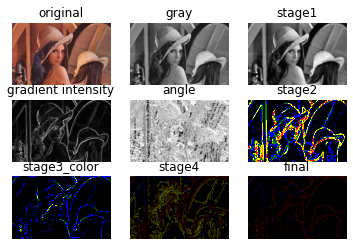

In [32]:
#show
map = mpl.colors.ListedColormap(['black','blue', 'green', 'yellow', 'orange', 'red'])


plt.subplot(3,3,1), plt.title("original")
plt.imshow(original),plt.axis('off')
plt.subplot(3,3,2), plt.title("gray")
plt.imshow(img_gray,cmap='gray'),plt.axis('off')
plt.subplot(3,3,3), plt.title("stage1")
plt.imshow(stage1,cmap='gray'),plt.axis('off')
plt.subplot(3,3,4), plt.title("gradient intensity")
plt.imshow(GI,cmap='gray'),plt.axis('off')
plt.subplot(3,3,5), plt.title("angle")
plt.imshow(angle,cmap='gray'),plt.axis('off')
plt.subplot(3,3,6), plt.title("stage2")
plt.imshow(stage2,cmap=map,vmin=0, vmax=high_th+low_th),plt.axis('off')
plt.subplot(3,3,7), plt.title("stage3_color")
plt.imshow(stage3,cmap=map,vmin=0, vmax=high_th),plt.axis('off')
plt.subplot(3,3,8), plt.title("stage4")
plt.imshow(stage4torgb),plt.axis('off')
plt.subplot(3,3,9), plt.title("final")
plt.imshow(final2rgb),plt.axis('off')

plt.show()

